# Trial for Waste Material Using YOLOv8

Data Source: [
GARBAGE CLASSIFICATION 3 Computer Vision Project](https://universe.roboflow.com/material-identification/garbage-classification-3)

## 1.0 Import libraries and setup Ultralytics

In [ ]:
# Import essential libraries for the deep learning
import requests
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# Install Ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## 2.0 Connecting GPU for the YOLO Detection Task

In [ ]:
!nvidia-smi

Sat Jun 22 04:03:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 3.0 Download the waste material dataset

In [ ]:
import gdown

url = "https://drive.google.com/file/d/1GqHghiTZWQzUVJ1gqozeT7rQoDT1gblG/view?usp=sharing"
file_id = url.split("/")[-2]
prefix = "https://drive.google.com/uc?export=download&id="

gdown.download(prefix + file_id)
print("Data downloaded!")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1GqHghiTZWQzUVJ1gqozeT7rQoDT1gblG
From (redirected): https://drive.google.com/uc?export=download&id=1GqHghiTZWQzUVJ1gqozeT7rQoDT1gblG&confirm=t&uuid=1542812b-75fd-4e01-94c2-62e2ebd2908e
To: /content/waste-material-classification.zip
100%|██████████| 211M/211M [00:04<00:00, 50.4MB/s]

Data downloaded!


In [ ]:
!unzip waste-material-classification.zip
!rm -rf waste-material-classification.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/plastic1018_jpg.rf.1127bc64321e3586f399f1cb4aa44d33.txt  
 extracting: train/labels/plastic1019_jpg.rf.cd6baab15a8fc8c113122a3624de2672.txt  
 extracting: train/labels/plastic1021_jpg.rf.cc8873ffce8bdd8ccdf550312636bc3c.txt  
 extracting: train/labels/plastic1022_jpg.rf.7ab0defd116164a33ecb2542837252d9.txt  
 extracting: train/labels/plastic1023_jpg.rf.e7413da8aea1ac0a3bf15613112608df.txt  
 extracting: train/labels/plastic1025_jpg.rf.7ac20af8be2c2f48b0561494247b06ba.txt  
 extracting: train/labels/plastic1026_jpg.rf.216c13a7ade4721cd71427478eb94f1f.txt  
 extracting: train/labels/plastic1027_jpg.rf.f4160ddd389746a18ea0391b039a11c3.txt  
 extracting: train/labels/plastic1028_jpg.rf.909d98c61d6dbf997c84f48c6102f1e5.txt  
 extracting: train/labels/plastic102_jpg.rf.e3460219567d7f9de2b82aca4eb8b0ec.txt  
 extracting: train/labels/plastic1030_jpg.rf.b9bb18d8333e2ecf6caf8a0291a9a6ed.txt  
 extracting: train/labels/

In [ ]:
# Check the waste material class for the dataset
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']

roboflow:
  workspace: material-identification
  project: garbage-classification-3
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/material-identification/garbage-classification-3/dataset/2

## 4.0 YOLOv8 Large Model Training

Machine Learning Parameters: [Train - Ultralytics](https://docs.ultralytics.com/modes/train/)
- model: yolov8n; yolov8l
- epochs: 50 - 100
- imgsz: 640

**Note that the learning usually takes around 1-2 hours for training, for large data set, it might takes 6 hours or above for the training.

For the waste_material training

- model: Yolov8n
- epochs: 50

In [ ]:
# Model training, model = YOLOv8n; epochs=50
!yolo task=detect mode=train model=yolov8n.pt data="../content/data.yaml" epochs=50 batch=16 imgsz=640 name=waste_yolov8n_01 exist_ok=True amp=False

100% 6.23M/6.23M [00:00<00:00, 110MB/s]
Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=../content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=waste_yolov8n_01, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
# %load_ext tensorboard
# %tensorboard --logdir runs

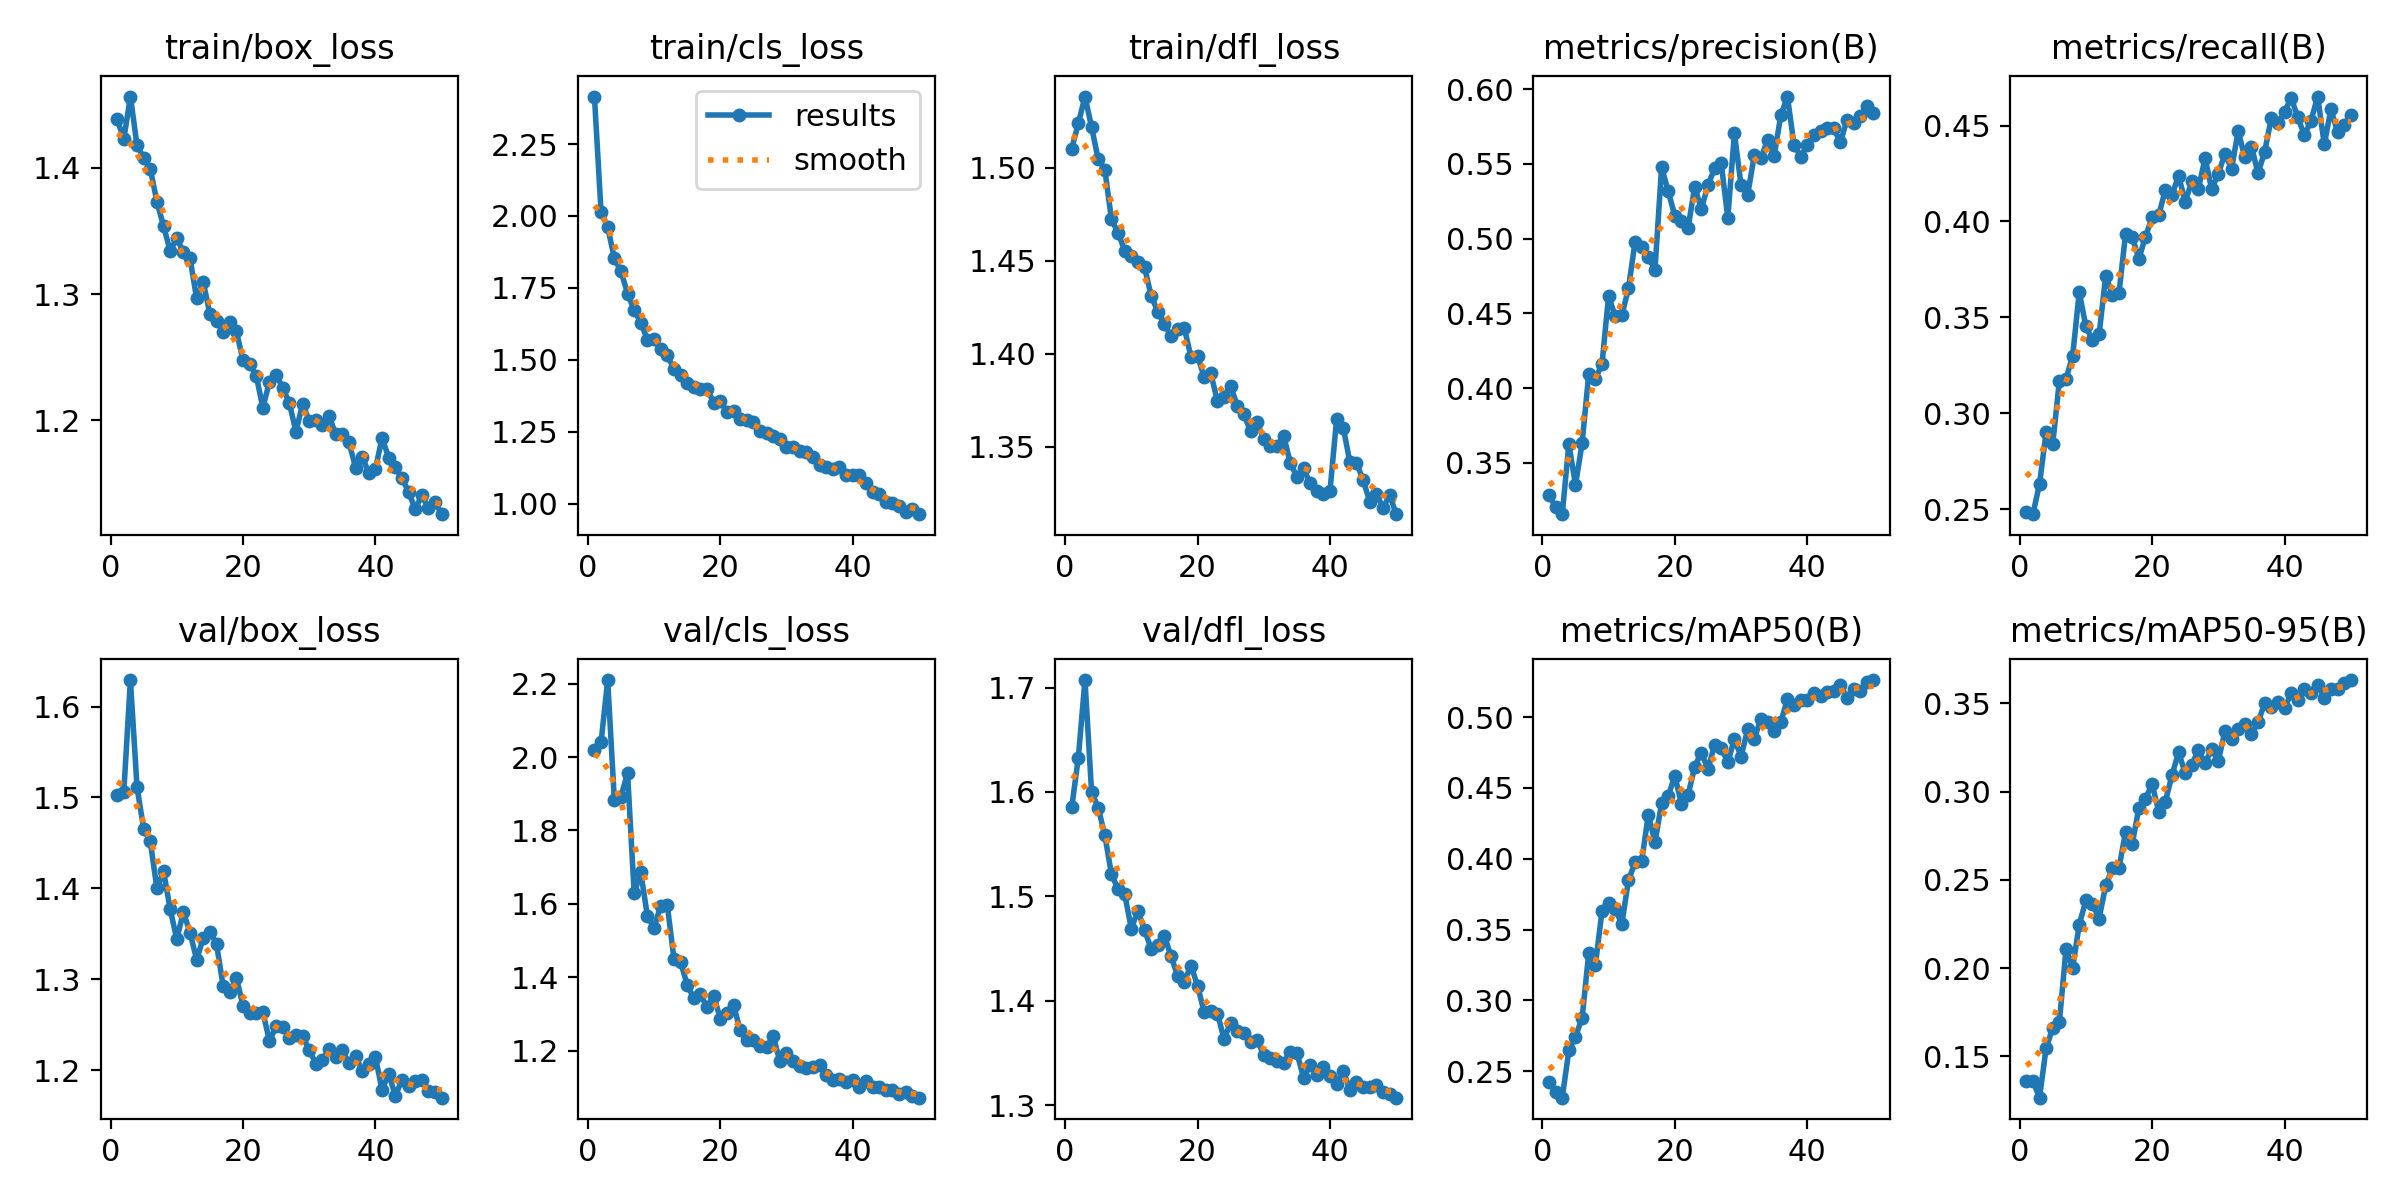

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from IPython.display import Image, clear_output # to display images
Image(filename='/content/runs/detect/waste_yolov8n_01/results.png', width=1000)  # view results.png

In [ ]:
!yolo predict \
model='/content/runs/detect/waste_yolov8n_01/weights/best.pt' \
source='/content/valid/images' \
name='yolov8n_predict' \
exist_ok=True \
save=True

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs

image 1/2098 /content/valid/images/biodegradable1000_jpg.rf.9407ff66b4ccd9f8eb5545be8f3225f4.jpg: 640x640 19 BIODEGRADABLEs, 24.9ms
image 2/2098 /content/valid/images/biodegradable1004_jpg.rf.645d319975e53c260b201677f2f39981.jpg: 640x640 46 BIODEGRADABLEs, 7.4ms
image 3/2098 /content/valid/images/biodegradable1005_jpg.rf.b7b1be167f526345b5969108f970527e.jpg: 640x640 2 GLASSs, 4 PLASTICs, 7.3ms
image 4/2098 /content/valid/images/biodegradable1014_jpg.rf.6c7191185080662606b4a93b0d38ad7b.jpg: 640x640 12 BIODEGRADABLEs, 7.3ms
image 5/2098 /content/valid/images/biodegradable1020_jpg.rf.ae69eadc714124b08e26002722c0fe25.jpg: 640x640 62 BIODEGRADABLEs, 7.3ms
image 6/2098 /content/valid/images/biodegradable1021_jpg.rf.edce77a139a17d3ffd827d56eb01603f.jpg: 640x640 1 BIODEGRADABLE, 7.3ms
image 7/2098 /content/valid/images/biodegrada

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in either a 1x1 grid or 2x2 grid.
    """
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    if len(image_names) < 4:
        plt.figure(figsize=(10, 7))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(1, 1, i+1)
            plt.imshow(image)
            plt.axis('off')
            break
    if len(image_names) >= 4:
        plt.figure(figsize=(15, 12))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(2, 2, i+1)
            plt.imshow(image)
            plt.axis('off')
            if i == 3:
                break
    plt.tight_layout()
    plt.show()

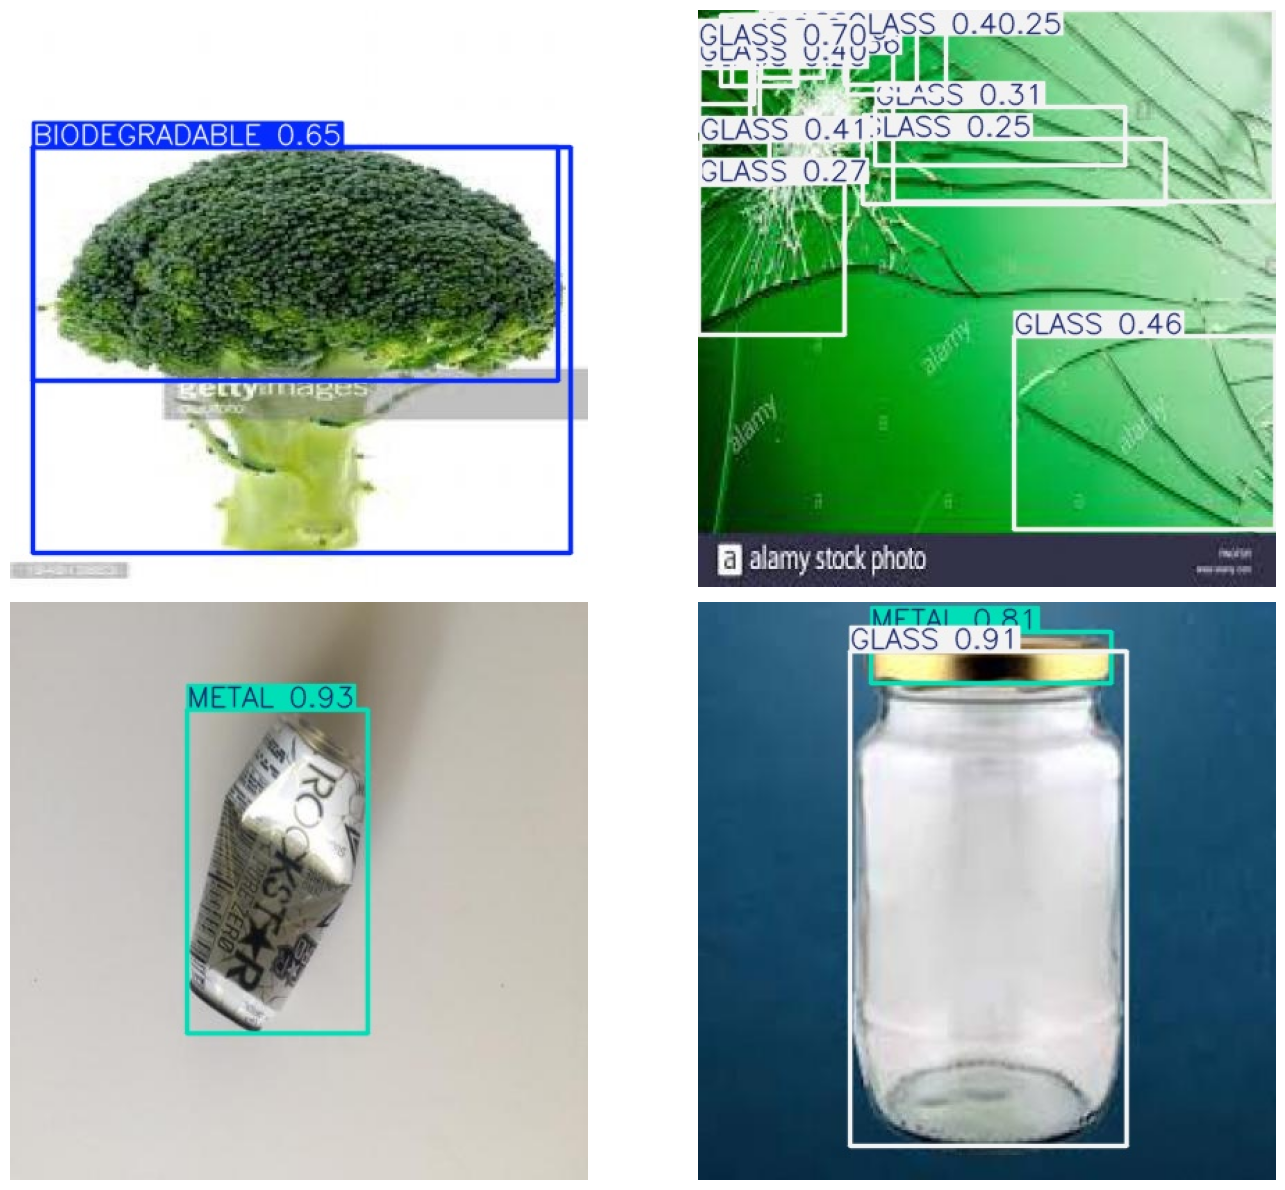

In [ ]:
visualize('/content/runs/detect/yolov8n_predict')

### Export Trained Weights for Future Inference
### Finish Training